## 3D Brain Segmentation Using 2D Fully Convolutional Neural Networks

##  Objectives

The goal of our experiments is to perform the brain extraction, also known as skull-stripping, using a 2D U-Shape fully convolutional neural network (CNN), which we chose the U-NET architecture. 


## Workflow

<img src="../figures/WorkflowRepPaper_2r.png" />

## Data

The dataset used is the CC-359 which  consists of T1 volumes acquired in 359 subjects on scanners from three different vendors (GE, Philips, and Siemens) and at two magnetic field strengths (1.5 T and 3 T). The dataset has twelve volumes with manual segmentations that will be used to evaluate the proposed method.

## Tools

In this project, we basically use python to code and ITK-SNAP to see the 3D volume.

## Libraries

NumPy, Scikit-Learn, Matplotlib, Keras

## References

[1] Kleesiek, J. et al. NeuroImage, 129:460–469, 2016. [2] Warfield, S. K. et al. IEEE Tran. on Med. Imaging, 23(7):903–921, 2004. [3] Ronneberger, O. et al, MICCAI, Springer, 9351: 234-241, 2015.

# Data Visualization

The following code is used to load and visualize the volume data that will be used during the project. Basically, it is imported some libraries in python to support the visualization, then it is show some plots of tha Nifti volmes with its respectives masks, either manual ou generated through the consensus among automatic methods. The last figure in this plot represents an example of 3D volume visualization on ITK-SNAP of an MRI image, the respective manual mask, and a 3D model of the mask.

# Importing Modules

In [1]:
import os
import glob
import nibabel as nib
import matplotlib.pylab as plt
import numpy as np

#  Auxiliary Functions

In [2]:
def create_new_dir(dstDir):
    
    if not os.path.exists(dstDir):
        os.makedirs(dstDir)

def read_file(filename):
    content = []
    f = open(filename,'r')
    content = np.sort([x.strip('\n') for x in f.readlines()])
    f.close()
    return content

def save_file(fname,data):
    
    f = open(fname,'w')
    for c in data:
        f.write('%s\n' % c)
    f.close()
    
def remove_manual_segs(manual_data_names,original_data_names):
    
    original_path = [name.split('/C')[0] for name in original_data_names]
    indexes = []
    
    manual = [name.split('/')[-1] for name in manual_data_names]
    original = [name.split('/')[-1] for name in original_data_names]
       
    for name in manual:
        name = name.split('_man')[0] + '.nii.gz'
        if name in original:
            indexes.append(original.index(name))
            original.remove(name) 

    [original_path.remove(original_path[idx]) for idx in indexes]
    original = [os.path.join(original_path[i],original[i]) for i in range(len(original))]

    return original

# Directories and filenames setup

In [3]:
# root directory
out = '/home/oeslle/Documents/MSc_Research/GPU_scripts/projects/IA369Z'
dataset = '/home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new'

txt = os.path.join(out,'txt')
create_new_dir(txt)

# data directory
data_path = os.path.join(dataset,'Original-Nifti/*/*/*.nii.gz')
manual_path = os.path.join(dataset,'Manual/Final/*/*/*man3.nii.gz')
consensus_path = os.path.join(dataset,'LR')

tr_original_filename = os.path.join(txt,'original_train.txt')
tr_consensus_filename = os.path.join(txt,'original_train_masks.txt')
manual_filename = os.path.join(txt,'original_test_masks.txt')
ts_original_filename = os.path.join(txt,'original_test.txt')


# Load and save data filenames

In [4]:
def run_load_save_data_names():
    
    original_data_names = glob.glob(data_path)
    manual_data_names = glob.glob(manual_path)
    
    # Incomplete manual segmentations
    manual_data_names.remove(os.path.join(dataset,'Manual/Final/GE/1.5T/CVCD01120013_man3.nii.gz'))
    manual_data_names.remove(os.path.join(dataset,'Manual/Final/GE/1.5T/CVCD01120136_man3.nii.gz'))

    # Removing subjects who have manual segmentations
    tr_original_data_names = remove_manual_segs(manual_data_names,original_data_names)
    tr_consensus_data_names = [os.path.join(consensus_path,name.split('/')[-1].split('.nii')[0]+ '_lr.nii.gz')
                               for name in tr_original_data_names]

    # Getting test data names
    ts_original_data_names = [x for x in original_data_names if x not in tr_original_data_names]    

    # Converting to numpy array
    tr_original_data_names = np.asarray(tr_original_data_names)
    ts_original_data_names = np.asarray(ts_original_data_names)
    manual_data_names = np.asarray(manual_data_names)
    tr_consensus_data_names = np.asarray(tr_consensus_data_names)

    save_file(tr_original_filename,tr_original_data_names)
    save_file(tr_consensus_filename,tr_consensus_data_names)
    save_file(manual_filename,manual_data_names)
    save_file(ts_original_filename,ts_original_data_names)

In [5]:
run_load_save_data_names()

# Plot data samples

## plotting test original and respective manual segmentations

Subject /home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new/Original-Nifti/GE/1.5T/CVCD01120001.nii.gz


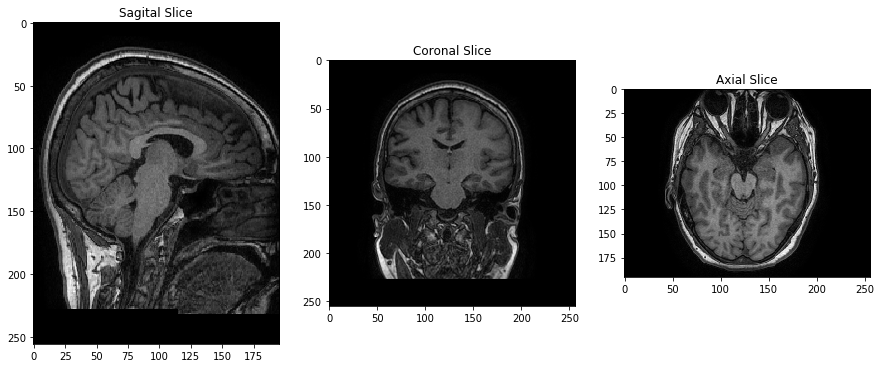

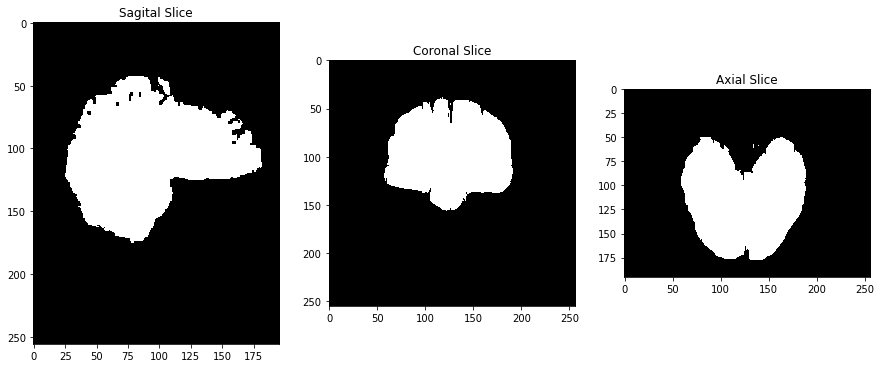

Subject /home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new/Original-Nifti/GE/1.5T/CVCD07030027.nii.gz


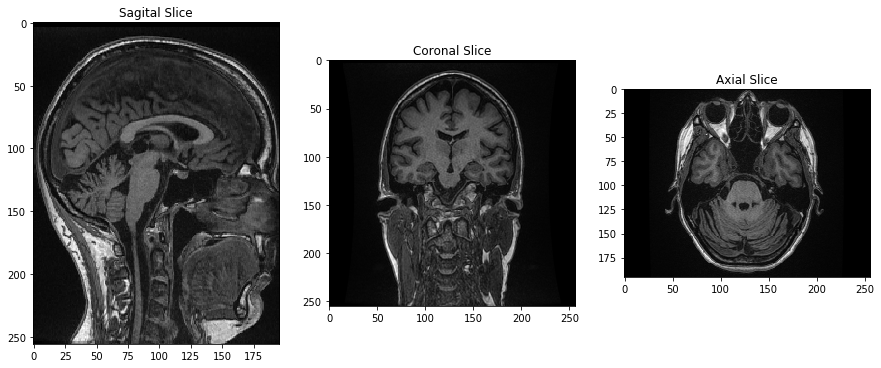

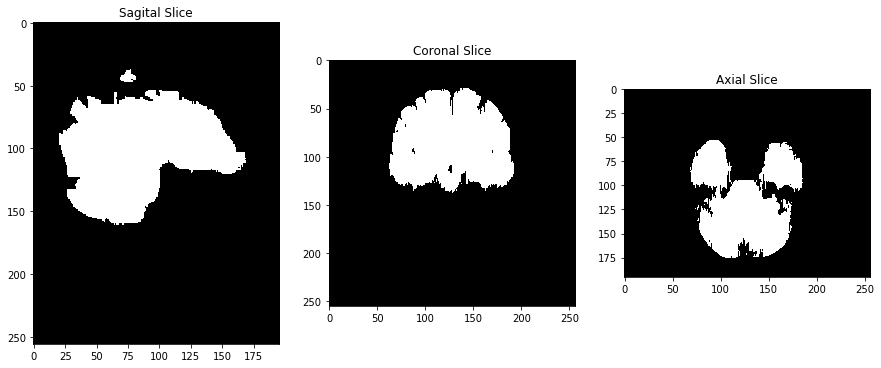

Subject /home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new/Original-Nifti/GE/3T/CVCD03060007.nii.gz


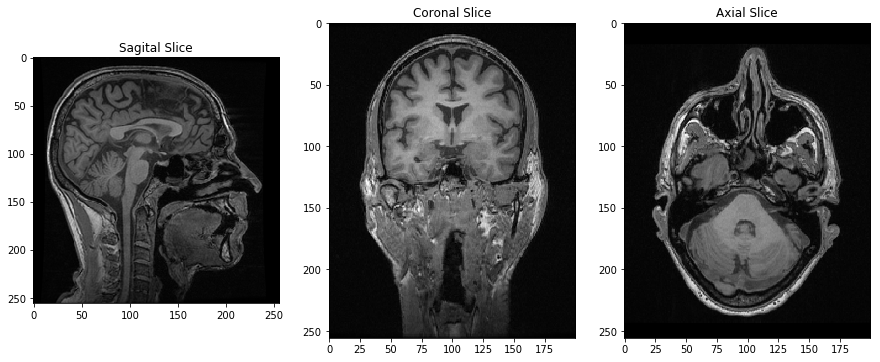

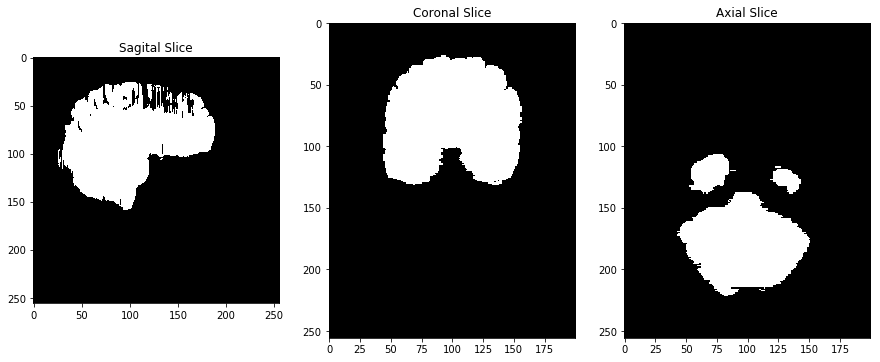

In [6]:
ts_original = read_file(ts_original_filename)
manual = read_file(manual_filename)

mask_prefix = [name.split('/C')[0] for name in manual]
mask_sufix = [name.split('/')[-1] for name in manual]

H,W = 15,25

for name in ts_original[:3]:
    
    print "Subject", name
    
    root = name.split('/')[-1].split('.nii.gz')[0] 
    aux = root + '_man3.nii.gz'
    idx = mask_sufix.index(aux)
    mask_name = os.path.join(mask_prefix[idx], mask_sufix[idx])
    
    volume_in = nib.load(name)
    data = nib.load(name).get_data()
    data = data.astype(np.float32)
    mask = nib.load(mask_name).get_data() 
    w,h,d = data.shape
    
    # Plot of the mid slices
    plt.figure(figsize=(H,W))
    plt.subplot(131)
    plt.imshow(data[w/2,:,:].T[::-1],cmap = 'gray')
    plt.title("Sagital Slice")
    plt.subplot(132)
    plt.imshow(data[:,h/2,:].T[::-1],cmap = 'gray')
    plt.title("Coronal Slice")
    plt.subplot(133)
    plt.imshow(data[:,:,d/2].T[::-1],cmap = 'gray')
    plt.title("Axial Slice")
    plt.show()
    
    plt.figure(figsize=(H,W))
    plt.subplot(131)
    plt.imshow(mask[w/2,:,:].T[::-1],cmap = 'gray')
    plt.title("Sagital Slice")
    plt.subplot(132)
    plt.imshow(mask[:,h/2,:].T[::-1],cmap = 'gray')
    plt.title("Coronal Slice")
    plt.subplot(133)
    plt.imshow(mask[:,:,d/2].T[::-1],cmap = 'gray')
    plt.title("Axial Slice")
    plt.show()

## plotting train original and respective consensus segmentations

Subject /home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new/Original-Nifti/GE/1.5T/CVCD01120003.nii.gz


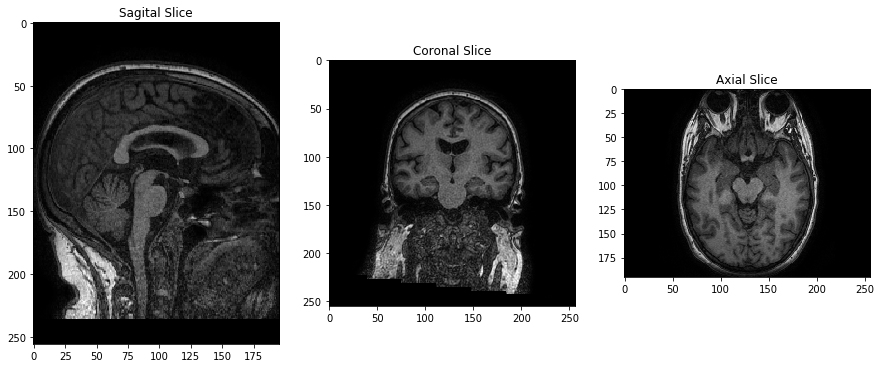

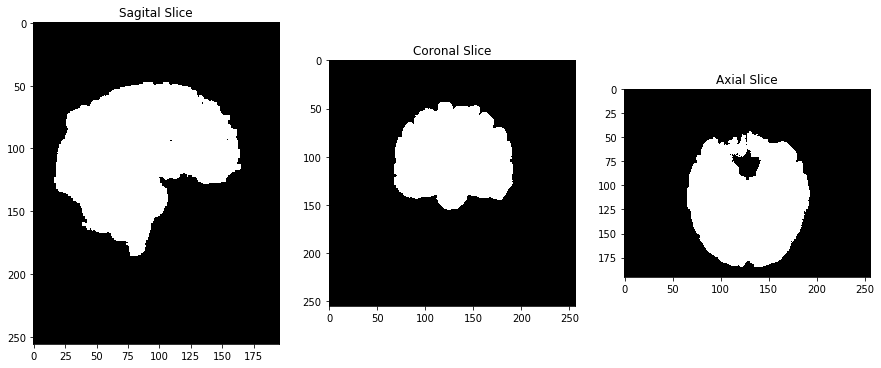

Subject /home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new/Original-Nifti/GE/1.5T/CVCD01120013.nii.gz


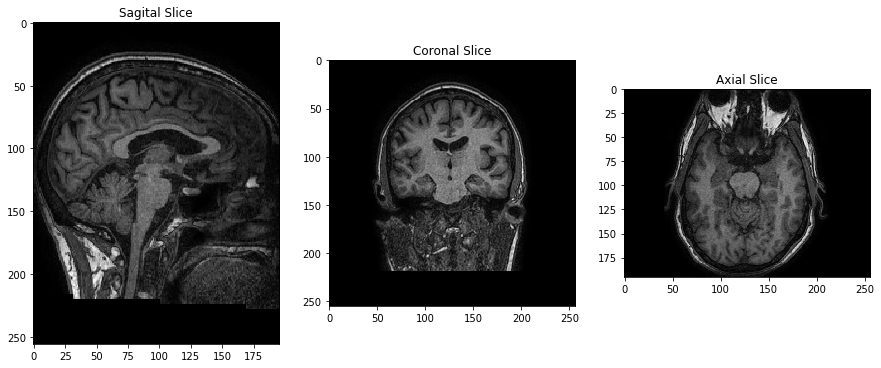

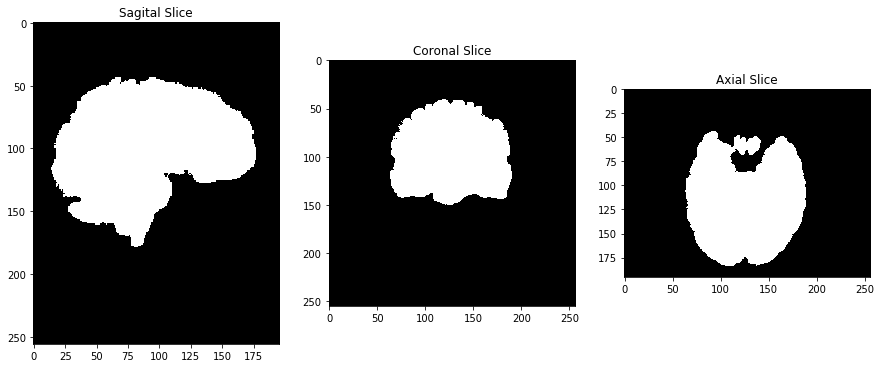

Subject /home/oeslle/Documents/MSc_Research/GPU_scripts/datasets/SS-new/Original-Nifti/GE/1.5T/CVCD01120016.nii.gz


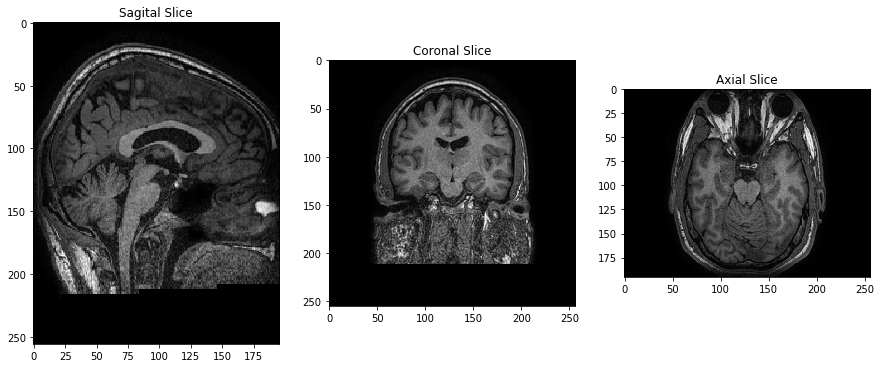

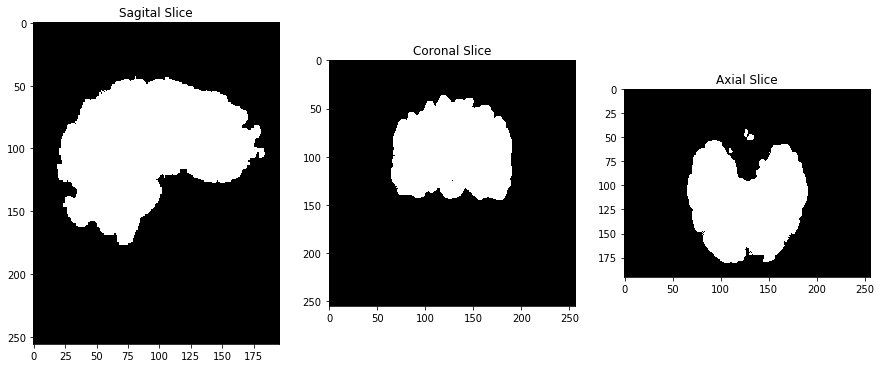

In [7]:
tr_original = read_file(tr_original_filename)
consensus = read_file(tr_consensus_filename)

H,W = 15,25

for name in tr_original[:3]:
    
    print "Subject", name
    
    root = name.split('/')[-1].split('.nii.gz')[0] 
    aux = root + '_lr.nii.gz'
    consensus_name = os.path.join(consensus_path, aux)
    
    volume_in = nib.load(name)
    data = nib.load(name).get_data()
    data = data.astype(np.float32)
    consensus = nib.load(consensus_name).get_data() 
    w,h,d = data.shape
    
    # Plot of the mid slices
    plt.figure(figsize=(H,W))
    plt.subplot(131)
    plt.imshow(data[w/2,:,:].T[::-1],cmap = 'gray')
    plt.title("Sagital Slice")
    plt.subplot(132)
    plt.imshow(data[:,h/2,:].T[::-1],cmap = 'gray')
    plt.title("Coronal Slice")
    plt.subplot(133)
    plt.imshow(data[:,:,d/2].T[::-1],cmap = 'gray')
    plt.title("Axial Slice")
    plt.show()
    
    plt.figure(figsize=(H,W))
    plt.subplot(131)
    plt.imshow(consensus[w/2,:,:].T[::-1],cmap = 'gray')
    plt.title("Sagital Slice")
    plt.subplot(132)
    plt.imshow(consensus[:,h/2,:].T[::-1],cmap = 'gray')
    plt.title("Coronal Slice")
    plt.subplot(133)
    plt.imshow(consensus[:,:,d/2].T[::-1],cmap = 'gray')
    plt.title("Axial Slice")
    plt.show()

# ITK-SNAP visualization

<img src="../figures/ITKSnap.png" />